# Step 1: Understanding Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [2]:
df = pd.read_csv('forestfires.csv')
df.head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


# Step 2: Data Preprocessing
1) Add a new column = size_category

In [3]:
df['size_category'] = np.where(df['area']>6, '1', '0')
df['size_category']= pd.to_numeric(df['size_category'])
df.tail(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
507,2,4,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0
508,1,2,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17,0
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43,0
511,8,6,aug,sun,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.00,0
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,1
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,1
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,1
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.00,0


2) Data Preprocessing for Days

C:\Users\smogili1\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Count plot of weekend vs weekday')

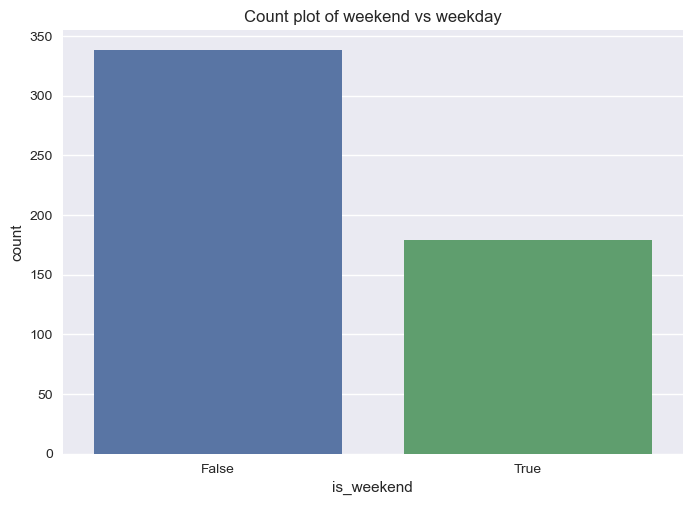

In [4]:
# converting to is weekend
df['day'] = ((df['day'] == 'sun') | (df['day'] == 'sat'))
# renaming column
df = df.rename(columns = {'day' : 'is_weekend'})
# visualizing
sns.countplot(df['is_weekend'])
plt.title('Count plot of weekend vs weekday')

In [5]:
# Create a mapping dictionary for months
month_mapping = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}

# Apply the mapping to the 'month' column in the original DataFrame 'df'
df['month'] = df['month'].map(month_mapping)

3) Scaling Area and Rain

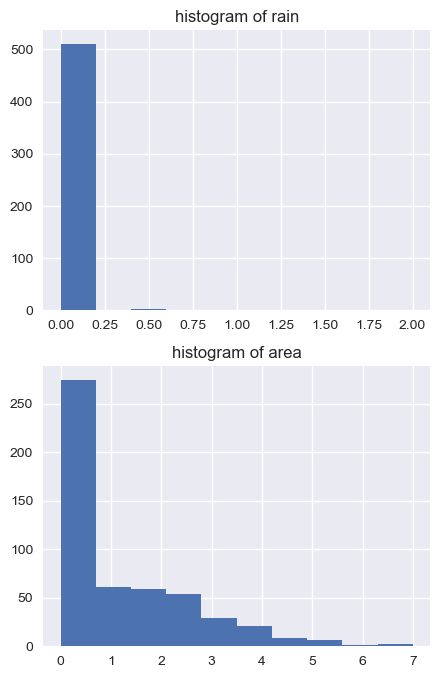

In [6]:
# natural logarithm scaling (+1 to prevent errors at 0)
df.loc[:, ['rain', 'area']] = df.loc[:, ['rain', 'area']].apply(lambda x: np.log(x + 1), axis = 1)
# visualizing
fig, ax = plt.subplots(2, figsize = (5, 8))
ax[0].hist(df['rain'])
ax[0].title.set_text('histogram of rain')
ax[1].hist(df['area'])
ax[1].title.set_text('histogram of area')

4) Train Test Split

In [7]:
features = df.drop(['size_category'], axis=1)
labels = df['size_category'].values.reshape(-1,1)
# encode categorical features using one-hot encoding
features = pd.get_dummies(features)
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2, random_state = 42)

5) Feature Scaling: StandardScaler

In [8]:
# fitting scaler
sc_features = StandardScaler()
# transforming features
X_test = sc_features.fit_transform(X_test)
X_train = sc_features.transform(X_train)
# features
X_test = pd.DataFrame(X_test, columns = features.columns)
X_train = pd.DataFrame(X_train, columns = features.columns)
# labels
y_test = pd.DataFrame(y_test, columns = ['size_category'])
y_train = pd.DataFrame(y_train, columns = ['size_category'])
X_train.head()

,X,Y,month,is_weekend,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,-0.293766,-0.927776,0.672240,1.404076,0.342959,-0.060220,0.867158,-0.249015,0.784070,-1.071784,-0.054362,-0.137348,0.219260
1,-0.293766,-0.161993,0.672240,-0.712212,-0.057456,0.370353,0.600021,-0.465731,-0.203920,-0.279375,-1.042369,-0.137348,0.177491
2,-1.130796,0.603791,0.232536,-0.712212,0.312158,0.834731,0.483714,0.664288,0.221938,0.248898,-0.054362,-0.137348,0.180797
3,-0.712281,-0.161993,0.232536,-0.712212,1.544206,1.341810,0.537142,0.664288,2.283090,-1.071784,-1.042369,-0.137348,1.087255
4,0.124750,-0.161993,-2.405688,1.404076,-1.320305,-1.602809,-2.022846,-0.945602,-1.106740,0.645102,-1.042369,-0.137348,0.578923


# Step 3: Hyperparameter/ Experiment Results
1) Experiment 1 : Base Model

In [9]:
model = Sequential()
# input layer + 1st hidden layer
model.add(Dense(6, input_dim=13, activation='relu'))
# 2nd hidden layer
model.add(Dense(6, activation='relu'))
# output layer
model.add(Dense(6, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 84        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________


In [10]:
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

X_train['month'] = df.loc[X_train.index, 'month']
X_test['month'] = df.loc[X_test.index, 'month']

# Create DataFrames df_train and df_test
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

print(df_train.applymap(type).eq(str).any())
print(df_test.applymap(type).eq(str).any())

X             False
Y             False
month         False
is_weekend    False
FFMC          False
DMC           False
DC            False
ISI           False
temp          False
RH            False
wind          False
rain          False
area          False
dtype: bool
X             False
Y             False
month         False
is_weekend    False
FFMC          False
DMC           False
DC            False
ISI           False
temp          False
RH            False
wind          False
rain          False
area          False
dtype: bool


In [11]:
# Compile Model
model.compile(optimizer = 'adam', metrics=['accuracy'], loss ='binary_crossentropy')
# Train Model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 100)

Epoch 1/100
42/42 [==============================] - 1s 6ms/step - loss: 3.4789 - accuracy: 0.7119 - val_loss: 4.1541 - val_accuracy: 0.7308
Epoch 2/100
42/42 [==============================] - 0s 2ms/step - loss: 3.6478 - accuracy: 0.6998 - val_loss: 4.1540 - val_accuracy: 0.7308
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 3.8256 - accuracy: 0.6901 - val_loss: 4.1536 - val_accuracy: 0.7308
Epoch 4/100
42/42 [==============================] - 0s 2ms/step - loss: 3.7504 - accuracy: 0.6949 - val_loss: 4.0429 - val_accuracy: 0.7308
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 3.1648 - accuracy: 0.7022 - val_loss: 3.3446 - val_accuracy: 0.7308
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 2.8692 - accuracy: 0.6416 - val_loss: 2.8661 - val_accuracy: 0.7308
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 2.5838 - accuracy: 0.6513 - val_loss: 2.9619 - val_accuracy: 0.7308
Epoch 8/100
4

Epoch 59/100
42/42 [==============================] - 0s 2ms/step - loss: 0.3908 - accuracy: 0.8765 - val_loss: 0.1541 - val_accuracy: 0.9423
Epoch 60/100
42/42 [==============================] - 0s 2ms/step - loss: 0.2744 - accuracy: 0.8862 - val_loss: 0.1611 - val_accuracy: 0.9423
Epoch 61/100
42/42 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.9031 - val_loss: 0.1541 - val_accuracy: 0.9423
Epoch 62/100
42/42 [==============================] - 0s 2ms/step - loss: 0.3350 - accuracy: 0.8910 - val_loss: 0.1494 - val_accuracy: 0.9423
Epoch 63/100
42/42 [==============================] - 0s 2ms/step - loss: 0.2129 - accuracy: 0.9128 - val_loss: 0.1431 - val_accuracy: 0.9519
Epoch 64/100
42/42 [==============================] - 0s 2ms/step - loss: 0.2859 - accuracy: 0.8910 - val_loss: 0.1378 - val_accuracy: 0.9327
Epoch 65/100
42/42 [==============================] - 0s 2ms/step - loss: 0.2157 - accuracy: 0.9249 - val_loss: 0.1319 - val_accuracy: 0.9519
Epoch 

In [12]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.983, Valid: 0.952


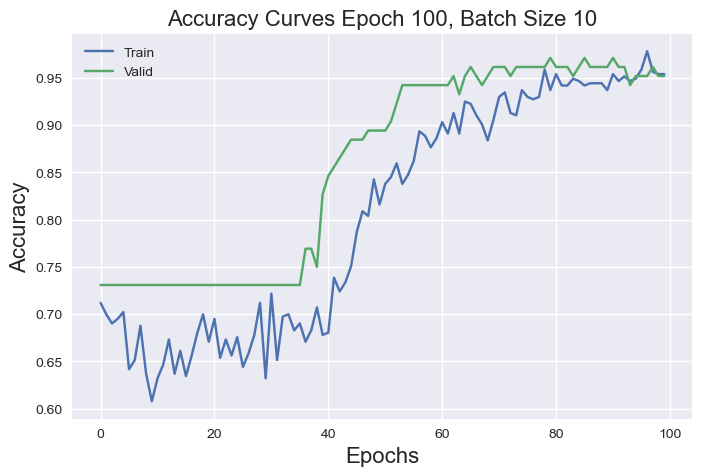

In [13]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves Epoch 100, Batch Size 10', fontsize=16)
plt.show()

2) Experiment 2: Batch Size: 4, 6, 10, 16, 32, 64, 128, 260

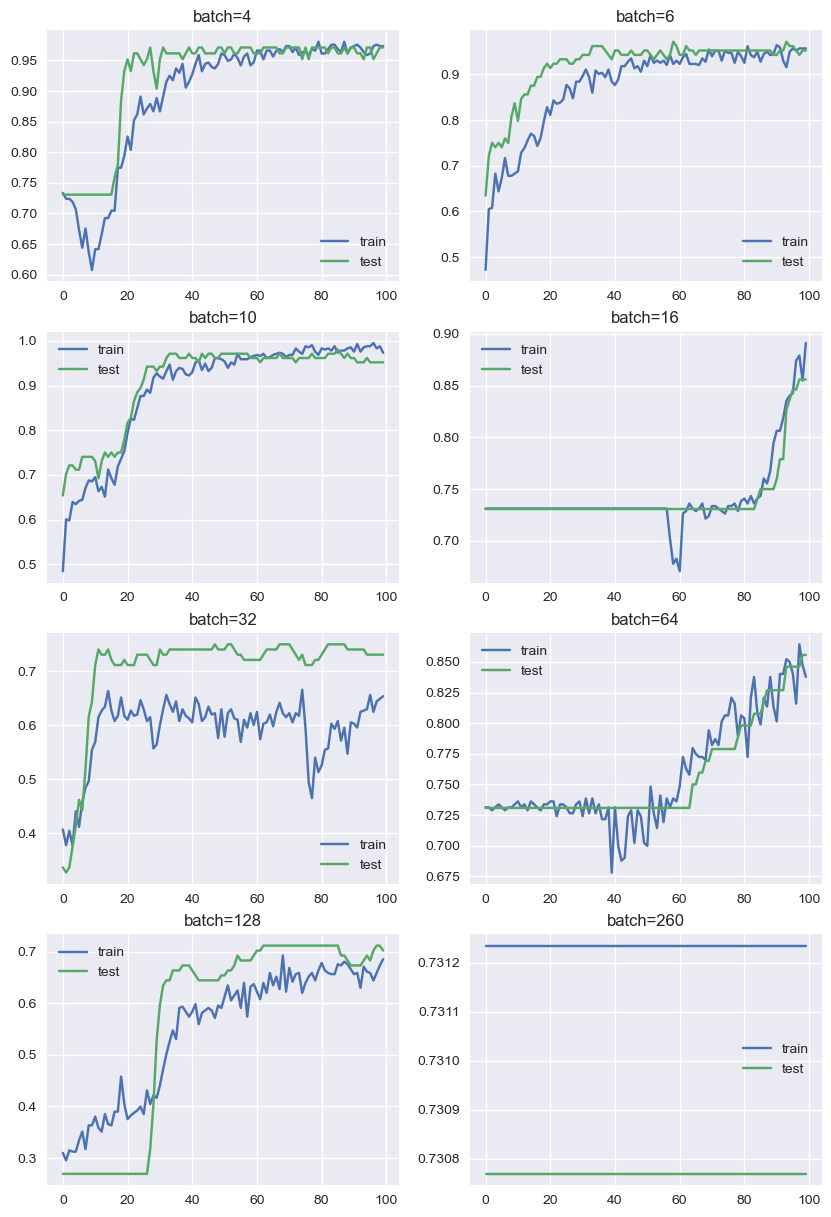

In [14]:
# Fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch):
    # Define Model
    model = Sequential()
    model.add(Dense(6, input_dim=13, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'relu'))
    # Compile Model
    model.compile(optimizer = 'adam',
    metrics=['accuracy'],
    loss = 'binary_crossentropy')
    # Fit Model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0, batch_size=n_batch)
    # Plot Learning Curves
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('batch='+str(n_batch))
    plt.legend()
    
# Create learning curves for different batch sizes
batch_sizes = [4, 6, 10, 16, 32, 64, 128, 260]
plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):
    # Determine the Plot Number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    # Fit model and plot learning curves for a batch size
    fit_model(X_train, y_train, X_test, y_test, batch_sizes[i])
# Show learning curves
plt.show()

3) Experiment 3: Batch Size = 6, Epochs = 20, 50, 100, 120, 150, 200, 300, 400

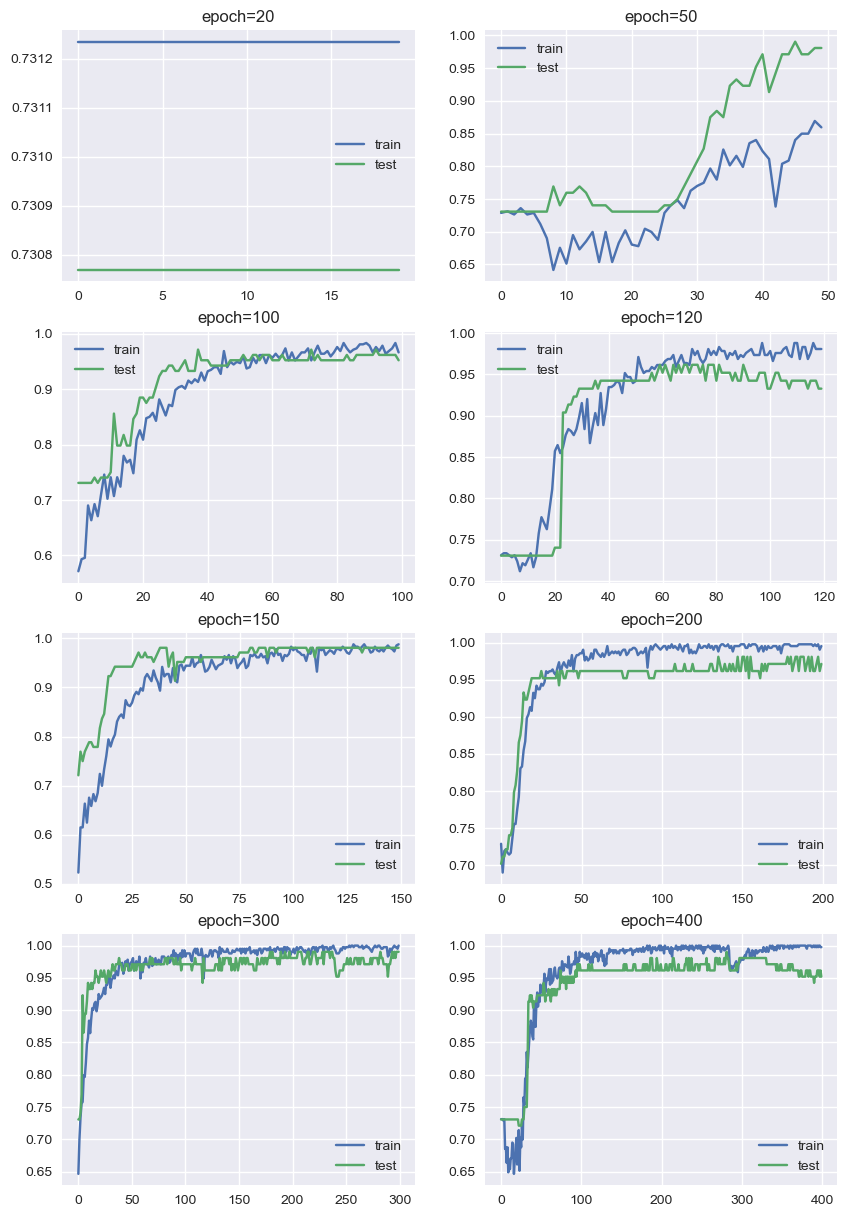

In [15]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, validX, validy, n_epoch):
    # define model
    model = Sequential()
    model.add(Dense(6, input_dim=13, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'relu'))
    # compile model
    model.compile(optimizer ='adam', metrics=['accuracy'], loss = 'binary_crossentropy')
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=n_epoch, verbose=0, batch_size=6)
    # plot learning curves
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('epoch='+str(n_epoch))
    plt.legend()
# Create learning curves for different batch sizes
epochs = [20, 50, 100, 120, 150, 200, 300, 400]
plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):
    # Determine the Plot Number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    # Fit model and plot learning curves for a batch size
    fit_model(X_train, y_train, X_test, y_test, epochs[i])
# Show learning curves
plt.show()

4) Experiment 4
Batch Size = 6, Early Stopping (Patience, Model Checkpoint)

In [16]:
def init_model():
    # define model
    model = Sequential()
    model.add(Dense(6, input_dim=13, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(6, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'relu'))
    model.compile(optimizer ='adam',
    metrics=['accuracy'],
    loss = 'binary_crossentropy')
    return model
# init model
model = init_model()
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
# model checkpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fitting model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, verbose=0, batch_size=6, callbacks=[es, mc])


Epoch 1: val_accuracy improved from -inf to 0.70192, saving model to best_model.h5

Epoch 2: val_accuracy improved from 0.70192 to 0.74038, saving model to best_model.h5

Epoch 3: val_accuracy improved from 0.74038 to 0.76923, saving model to best_model.h5

Epoch 4: val_accuracy improved from 0.76923 to 0.77885, saving model to best_model.h5

Epoch 5: val_accuracy did not improve from 0.77885

Epoch 6: val_accuracy improved from 0.77885 to 0.80769, saving model to best_model.h5

Epoch 7: val_accuracy improved from 0.80769 to 0.83654, saving model to best_model.h5

Epoch 8: val_accuracy did not improve from 0.83654

Epoch 9: val_accuracy did not improve from 0.83654

Epoch 10: val_accuracy improved from 0.83654 to 0.86538, saving model to best_model.h5

Epoch 11: val_accuracy improved from 0.86538 to 0.87500, saving model to best_model.h5

Epoch 12: val_accuracy did not improve from 0.87500

Epoch 13: val_accuracy did not improve from 0.87500

Epoch 14: val_accuracy improved from 0.875


Epoch 145: val_accuracy did not improve from 0.96154

Epoch 146: val_accuracy did not improve from 0.96154

Epoch 147: val_accuracy did not improve from 0.96154

Epoch 148: val_accuracy did not improve from 0.96154

Epoch 149: val_accuracy did not improve from 0.96154

Epoch 150: val_accuracy did not improve from 0.96154

Epoch 151: val_accuracy did not improve from 0.96154

Epoch 152: val_accuracy did not improve from 0.96154

Epoch 153: val_accuracy did not improve from 0.96154

Epoch 154: val_accuracy did not improve from 0.96154

Epoch 155: val_accuracy did not improve from 0.96154

Epoch 156: val_accuracy did not improve from 0.96154

Epoch 157: val_accuracy did not improve from 0.96154

Epoch 158: val_accuracy did not improve from 0.96154

Epoch 159: val_accuracy did not improve from 0.96154

Epoch 160: val_accuracy did not improve from 0.96154

Epoch 161: val_accuracy did not improve from 0.96154

Epoch 162: val_accuracy did not improve from 0.96154

Epoch 163: val_accuracy did

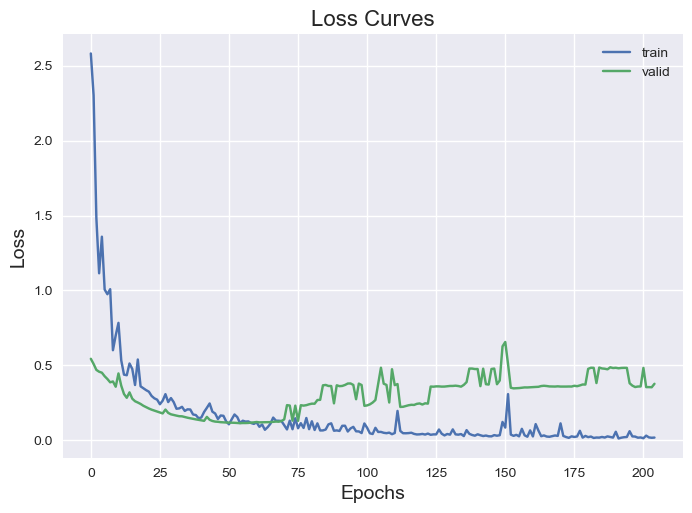

In [17]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

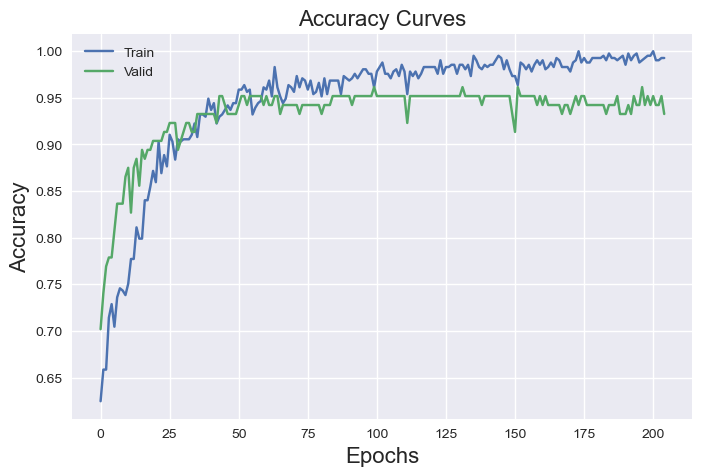

In [18]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

In [19]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 1.000, Valid: 0.933
